# Short term variability in DP2 

Can we measure short term variability (less than 1 wee) of AGN, using data from Rubin Data Preview 2. 

Planning document: https://docs.google.com/document/d/1U_OuIQrjCqC4iLNAIK9sChxuAPEEr-aRlTw1PRORF8Q 

### Imports

In [74]:
# --- stdlib ---
import os
import warnings
import logging

# --- environment (must be first) ---
os.environ.setdefault("NUMEXPR_MAX_THREADS", "64")

# --- third-party ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dask
from dask.distributed import Client

import pyarrow.parquet as pq
from upath import UPath
import s3fs

# --- project ---
import lsdb
import nested_pandas 
from lsdb import ConeSearch
from nested_pandas import NestedFrame, read_parquet
from nested_pandas.datasets import generate_parquet_file

# --- global configuration ---
warnings.simplefilter("ignore")

logging.getLogger("numexpr").setLevel(logging.WARNING)
logging.getLogger("distributed").setLevel(logging.WARNING)

dask.config.set({"dataframe.convert-string": False})

# --- diagnostics ---
print(f"lsdb version: {lsdb.__version__}")

lsdb version: 0.7.3


In [75]:
def structure_function(
    t,
    m,
    merr=None,
    bins=None,
    nbins=20,
    logbins=True,
    estimator="rms",          # "rms" (mean of squared diffs) or "mad" (robust)
    subtract_noise=True,
    min_pairs=30,
):
    """
    Compute a 1st-order structure function SF(Δt) from irregular time-series.

    Parameters
    ----------
    t : array-like
        Times (e.g., HMJD).
    m : array-like
        Magnitudes.
    merr : array-like or None
        Magnitude uncertainties (1-sigma). If provided and subtract_noise=True,
        subtracts <σ_i^2 + σ_j^2> from <(Δm)^2>.
    bins : array-like or None
        Bin edges in same units as t. If None, constructed from data range.
    nbins : int
        Number of bins if bins is None.
    logbins : bool
        If True, bins are log-spaced in Δt.
    estimator : {"rms","mad"}
        "rms": SF = sqrt( <(Δm)^2> - <noise> )
        "mad": SF = 1.4826 * median(|Δm - median(Δm)|)   (no noise subtraction)
    subtract_noise : bool
        Only used for estimator="rms".
    min_pairs : int
        Minimum number of pairs required per bin.

    Returns
    -------
    out : dict
        Keys: 'bin_edges', 'bin_centers', 'sf', 'sf_err', 'npairs'
        sf_err is a simple standard error estimate for the RMS estimator;
        for MAD it is set to NaN.
    """
    t = np.asarray(t, dtype=float)
    m = np.asarray(m, dtype=float)
    if merr is None:
        merr = None
    else:
        merr = np.asarray(merr, dtype=float)

    good = np.isfinite(t) & np.isfinite(m)
    if merr is not None:
        good &= np.isfinite(merr)

    t, m = t[good], m[good]
    if merr is not None:
        merr = merr[good]

    n = t.size
    if n < 2:
        raise ValueError("Need at least 2 valid points.")

    # Pairwise differences (upper triangle)
    dt = np.abs(t[:, None] - t[None, :])
    dm = m[:, None] - m[None, :]
    iu = np.triu_indices(n, k=1)
    dt = dt[iu]
    dm = dm[iu]

    if merr is not None:
        noise2 = (merr[:, None] ** 2 + merr[None, :] ** 2)[iu]
    else:
        noise2 = None

    # Define bins
    if bins is None:
        dt_pos = dt[dt > 0]
        if dt_pos.size == 0:
            raise ValueError("All time differences are zero.")
        dt_min = np.nanmin(dt_pos)
        dt_max = np.nanmax(dt_pos)
        if logbins:
            bins = np.logspace(np.log10(dt_min), np.log10(dt_max), nbins + 1)
        else:
            bins = np.linspace(dt_min, dt_max, nbins + 1)
    else:
        bins = np.asarray(bins, dtype=float)

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    sf = np.full(bin_centers.shape, np.nan, dtype=float)
    sf_err = np.full(bin_centers.shape, np.nan, dtype=float)
    npairs = np.zeros(bin_centers.shape, dtype=int)

    # Bin and estimate
    which = np.digitize(dt, bins) - 1
    for k in range(len(bin_centers)):
        sel = which == k
        npairs[k] = int(np.sum(sel))
        if npairs[k] < min_pairs:
            continue

        dmk = dm[sel]

        if estimator.lower() == "mad":
            # robust scatter of Δm (no noise subtraction)
            med = np.median(dmk)
            sf[k] = 1.4826 * np.median(np.abs(dmk - med))
            sf_err[k] = np.nan
        else:
            # RMS-based SF with optional noise subtraction
            dm2_mean = np.mean(dmk * dmk)
            if subtract_noise and (noise2 is not None):
                noise2_mean = np.mean(noise2[sel])
            else:
                noise2_mean = 0.0

            sf2 = dm2_mean - noise2_mean
            sf2 = max(sf2, 0.0)  # guard against negative due to noise over-subtraction
            sf[k] = np.sqrt(sf2)

            # very rough uncertainty (standard error on Δm^2 propagated)
            dm2 = dmk * dmk
            dm2_var = np.var(dm2, ddof=1)
            dm2_sem = np.sqrt(dm2_var / npairs[k])
            sf_err[k] = 0.5 * dm2_sem / max(sf[k], 1e-12)

    return {
        "bin_edges": bins,
        "bin_centers": bin_centers,
        "sf": sf,
        "sf_err": sf_err,
        "npairs": npairs,
    }

In [76]:
# set up Dask client for parallel computing

os.environ.setdefault("JUPYTERHUB_PUBLIC_URL", "http://127.0.0.1")
client = Client(n_workers=4, threads_per_worker=1, memory_limit="64GB");
# Print the dashboard link and port
print(f"Dask is running at: {client.dashboard_link}")

Dask is running at: http://127.0.0.1proxy/14489/status


In [77]:
# Set up S3 filesystem access - I need this to access IRSA ZTF data from SLAC machines

fs = s3fs.S3FileSystem(
    anon=True,
    client_kwargs={
        "region_name": "us-east-1",
        "endpoint_url": "https://s3.us-east-1.amazonaws.com",
    },
)

print(fs.s3.meta.endpoint_url)
print(fs.ls("ipac-irsa-ztf/contributed/dr23/objects/hats")[:5])

https://s3.us-east-1.amazonaws.com
['ipac-irsa-ztf/contributed/dr23/objects/hats/collection.properties', 'ipac-irsa-ztf/contributed/dr23/objects/hats/ztf_dr23_objects-hats', 'ipac-irsa-ztf/contributed/dr23/objects/hats/ztf_dr23_objects-hats_index_oid', 'ipac-irsa-ztf/contributed/dr23/objects/hats/ztf_dr23_objects-hats_margin_10arcsec']


## 1. Creating crossmatched dataset

## 1.1. Import raw data

In [78]:
# Import the ZTF DR23 object HATS catalog
path = UPath(
    "s3://ipac-irsa-ztf/contributed/dr23/objects/hats",
    anon=True,
    client_kwargs={
        "region_name": "us-east-1",
        "endpoint_url": "https://s3.us-east-1.amazonaws.com",
    },
)

obj_ZTF_23 = lsdb.open_catalog(path, columns=['oid', 'ra', 'dec', 'ngoodobs', 'weightedmagrms', 'medianabsdev', 'vonneumannratio', 'fid', 'medianmag' ])
obj_ZTF_23

,oid,ra,dec,ngoodobs,weightedmagrms,medianabsdev,vonneumannratio,fid,medianmag
npartitions=1791,,,,,,,,,
"Order: 3, Pixel: 0",int64[pyarrow],double[pyarrow],double[pyarrow],int32[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],float[pyarrow]
"Order: 3, Pixel: 1",...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
"Order: 4, Pixel: 3070",...,...,...,...,...,...,...,...,...
"Order: 4, Pixel: 3071",...,...,...,...,...,...,...,...,...


In [79]:
# Import Rubin DP1 HATS object catalog
obj_DP1 = lsdb.open_catalog('/sdf/data/rubin/shared/lsdb_commissioning/hats/v29_0_0/object_collection',\
    columns=['objectId', 'coord_ra', 'coord_dec', 'u_psfMag', 'g_psfMag', 'r_psfMag', 'i_psfMag', 'z_psfMag', 'y_psfMag','objectForcedSource'])
obj_DP1

,objectId,coord_ra,coord_dec,u_psfMag,g_psfMag,r_psfMag,i_psfMag,z_psfMag,y_psfMag,objectForcedSource
npartitions=389,,,,,,,,,,
"Order: 6, Pixel: 130",int64[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],"nested<parentObjectId: [int64], coord_ra: [dou..."
"Order: 8, Pixel: 2176",...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
"Order: 9, Pixel: 2302101",...,...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 143884",...,...,...,...,...,...,...,...,...,...


## 1.2. Crossmatch

In [80]:
DP1_ZTF_xmatch_plan = lsdb.crossmatch(obj_DP1, obj_ZTF_23, radius_arcsec=0.1)

In [81]:
# takes around 5 minutes
DP1_ZTF_xmatch = DP1_ZTF_xmatch_plan.compute()

## 1.3. Investigate the properties of the crossmatch

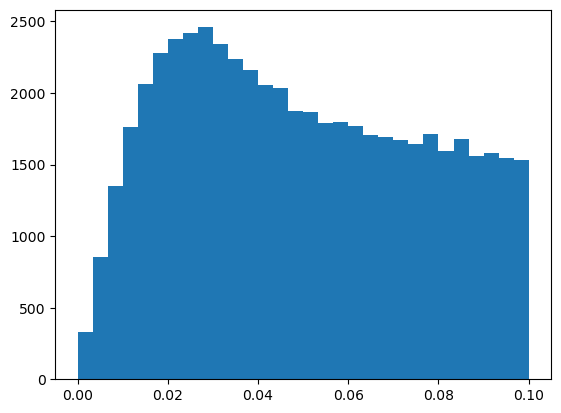

In [82]:
# there are 54000 lightcurves in ZTF DR23 that match to DP1 objects within 0.1 arcsec
plt.hist(DP1_ZTF_xmatch['_dist_arcsec'], bins=30);

In [83]:
# Define the six fields from Data Preview 1 with RA and Dec coordinates
fields = {
    "ECDFS": (53.13, -28.10),  # Extended Chandra Deep Field South
    "EDFS": (59.10, -48.73),  # Euclid Deep Field South
    "Rubin_SV_38_7": (37.86, 6.98),  # Low Ecliptic Latitude Field
    "Rubin_SV_95_-25": (95.00, -25.00),  # Low Galactic Latitude Field
    "47_Tuc": (6.02, -72.08),  # 47 Tuc Globular Cluster
    "Fornax_dSph": (40.00, -34.45),  # Fornax Dwarf Spheroidal Galaxy
    "Seagull": (106.30, -10.51)  # Seagull Nebula
}

# Define a 2-degree (2*3600 arcseconds) search radius
radius_arcsec = 2 * 3600  # Convert 2 degree to arcseconds
# Create six cone searches
cones = {name: ConeSearch(ra=ra, dec=dec, radius_arcsec=radius_arcsec) for name, (ra, dec) in fields.items()}

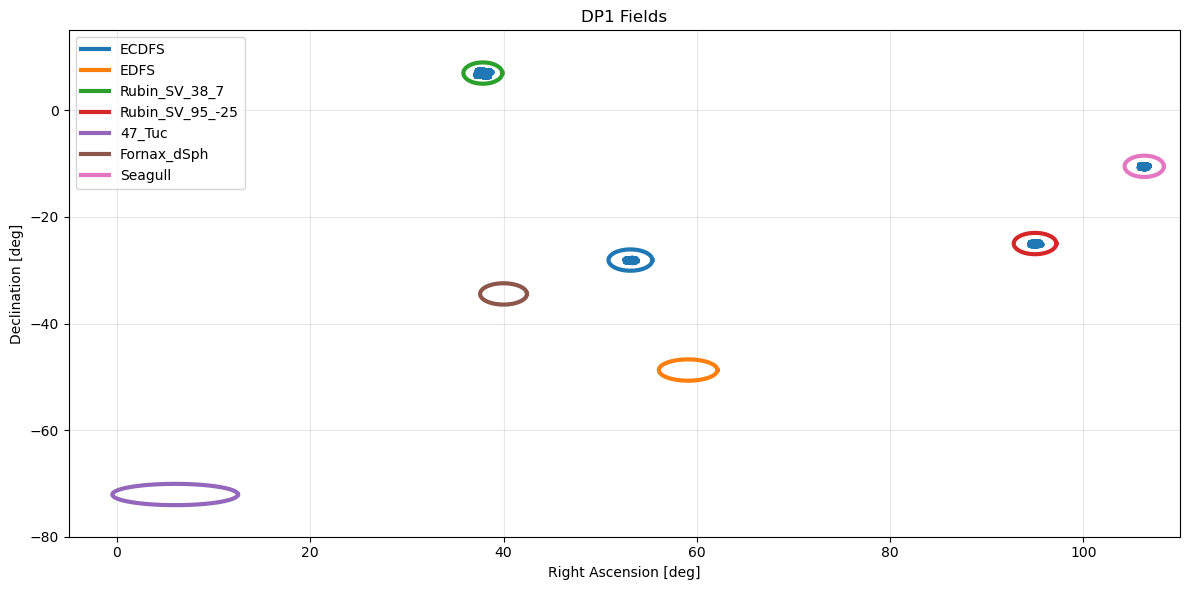

In [84]:

radius_deg = radius_arcsec / 3600.0  # 2 deg
theta = np.linspace(0, 2 * np.pi, 512)

fig, ax = plt.subplots(figsize=(12, 6))

# Background points: wrap RA to [-180, 180]
ra_bg = DP1_ZTF_xmatch["coord_ra_object_lc"].to_numpy()
ra_bg = ((ra_bg + 180) % 360) - 180
dec_bg = DP1_ZTF_xmatch["coord_dec_object_lc"].to_numpy()

ax.scatter(
    ra_bg,
    dec_bg,
    s=1,
    alpha=0.3,
    rasterized=True,
)

# Field circles
for name, (ra0, dec0) in fields.items():
    dec0_rad = np.deg2rad(dec0)

    ra = ra0 + (radius_deg * np.cos(theta)) / np.cos(dec0_rad)
    dec = dec0 + radius_deg * np.sin(theta)

    # wrap circle RA to [-180, 180]
    ra = ((ra + 180) % 360) - 180

    ax.plot(
        ra,
        dec,
        linewidth=3,
        label=name,
    )

# Axes formatting
ax.set_xlim(-5, 110)
ax.set_ylim(-80, 15)
ax.set_xlabel("Right Ascension [deg]")
ax.set_ylabel("Declination [deg]")
ax.set_title("DP1 Fields")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left", frameon=True)

plt.tight_layout()
plt.show()

In [85]:
DP1_ZTF_xmatch

objectId_object_lc  coord_ra_object_lc  \
_healpix_29                                                   
9193771653802800     648369431235265644           38.167419   
9193815210727380     648369362515787792           38.181318   
...                                 ...                 ...   
2530270978491866923  611257134226605931           53.258119   
2530271075840175194  611257134226605939           53.240364   

                     coord_dec_object_lc  u_psfMag_object_lc  \
_healpix_29                                                    
9193771653802800                5.994349                <NA>   
9193815210727380                6.000302                <NA>   
...                                  ...                 ...   
2530270978491866923           -27.422548                <NA>   
2530271075840175194           -27.412332                <NA>   

                     g_psfMag_object_lc  r_psfMag_object_lc  \
_healpix_29                                                   
9193771653802800              23.268278                <NA>   
9193815210727380               22.49909                <NA>   
...                                 ...                 ...   
2530270978491866923             22.1847                <NA>   
2530271075840175194           22.493025                <NA>   

                     i_psfMag_object_lc  z_psfMag_object_lc  \
_healpix_29                                                   
9193771653802800                   <NA>                <NA>   
9193815210727380                   <NA>                <NA>   
...                                 ...                 ...   
2530270978491866923                <NA>                <NA>   
2530271075840175194                <NA>                <NA>   

                     y_psfMag_object_lc  \
_healpix_29                               
9193771653802800                   <NA>   
9193815210727380                   <NA>   
...                                 ...   
2530270978491866923                <NA>   
2530271075840175194                <NA>   

                                          objectForcedSource_object_lc  \
_healpix_29                                                              
9193771653802800     [{parentObjectId: 0, coord_ra: 38.167419, coor...   
9193815210727380     [{parentObjectId: 0, coord_ra: 38.181318, coor...   
...                                                                ...   
2530270978491866923  [{parentObjectId: 0, coord_ra: 53.258119, coor...   
2530271075840175194  [{parentObjectId: 0, coord_ra: 53.240364, coor...   

                     oid_ZTF_DR23_Objects  ra_ZTF_DR23_Objects  \
_healpix_29                                                      
9193771653802800          452212100027729            38.167412   
9193815210727380          452212100003724            38.181299   
...                                   ...                  ...   
2530270978491866923      1246209400004589             53.25811   
2530271075840175194       252102300009315            53.240348   

                     dec_ZTF_DR23_Objects  ngoodobs_ZTF_DR23_Objects  \
_healpix_29                                                            
9193771653802800                 5.994326                          7   
9193815210727380                 6.000286                        230   
...                                   ...                        ...   
2530270978491866923            -27.422557                         14   
2530271075840175194            -27.412339                          1   

                     weightedmagrms_ZTF_DR23_Objects  \
_healpix_29                                            
9193771653802800                                <NA>   
9193815210727380                                <NA>   
...                                              ...   
2530270978491866923                             <NA>   
2530271075840175194                             <NA>   

                     medianabsdev_ZTF_DR23_Objects  \
_healpix_2

In [86]:
# Save the crossmatch to a parquet file
DP1_ZTF_xmatch.to_parquet('/sdf/home/n/ncaplar/github/short_var_AGN/DP1_ZTF_DR23_xmatch_v1.parquet')

# 2. Selection and filtering of the object-level dataset

In [87]:
# read the data back in
DP1_ZTF_xmatch = pq.read_table('/sdf/home/n/ncaplar/github/short_var_AGN/DP1_ZTF_DR23_xmatch_v1.parquet').to_pandas()

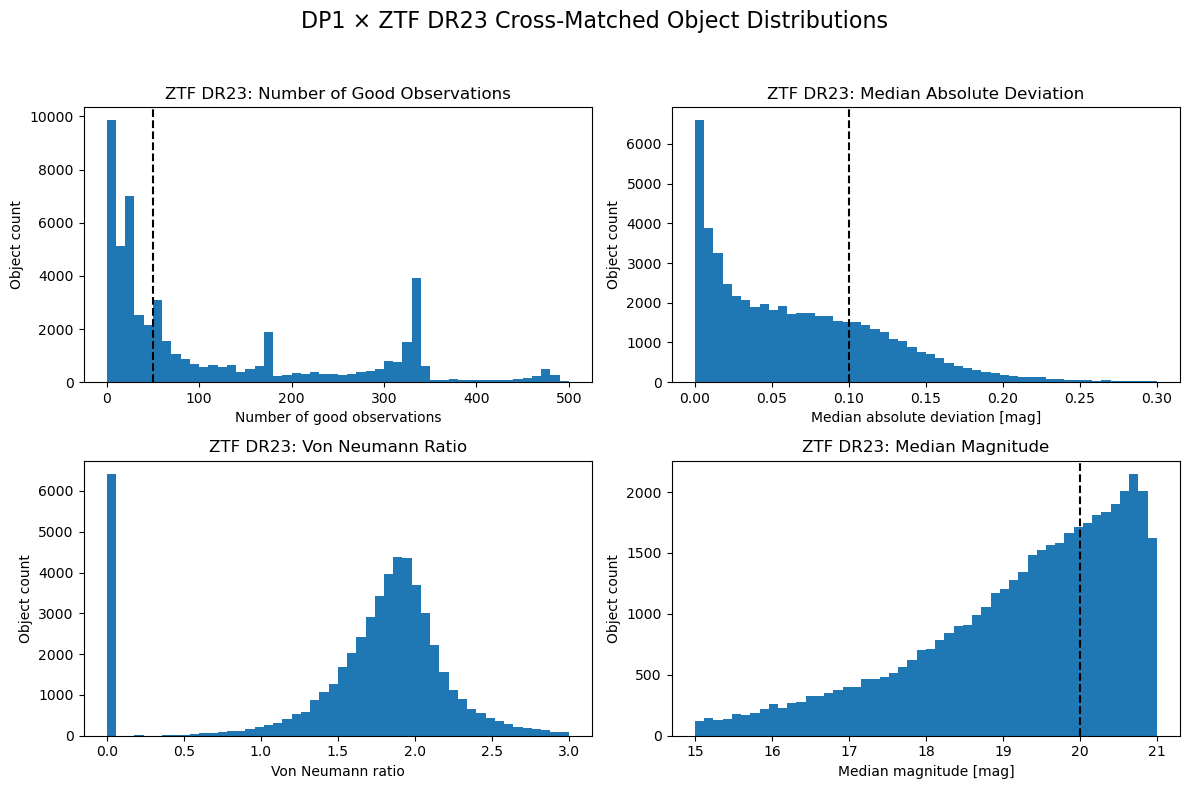

In [88]:
plt.figure(figsize=(12, 8))

# 1. Number of good ZTF observations
plt.subplot(2, 2, 1)
plt.hist(
    DP1_ZTF_xmatch["ngoodobs_ZTF_DR23_Objects"],
    bins=50,
    range=(0, 500),
)
plt.axvline(50, linestyle="--", color='black')
plt.title("ZTF DR23: Number of Good Observations")
plt.xlabel("Number of good observations")
plt.ylabel("Object count")

# 2. Median absolute deviation
plt.subplot(2, 2, 2)
plt.hist(
    DP1_ZTF_xmatch["medianabsdev_ZTF_DR23_Objects"],
    bins=50,
    range=(0, 0.3),
)
plt.axvline(0.1, linestyle="--", color='black')
plt.title("ZTF DR23: Median Absolute Deviation")
plt.xlabel("Median absolute deviation [mag]")
plt.ylabel("Object count")

# 3. Von Neumann ratio
plt.subplot(2, 2, 3)
plt.hist(
    DP1_ZTF_xmatch["vonneumannratio_ZTF_DR23_Objects"],
    bins=50,
    range=(0, 3),
)

plt.title("ZTF DR23: Von Neumann Ratio")
plt.xlabel("Von Neumann ratio")
plt.ylabel("Object count")

# 4. Median magnitude
plt.subplot(2, 2, 4)
plt.hist(
    DP1_ZTF_xmatch["medianmag_ZTF_DR23_Objects"],
    bins=50,
    range=(15, 21),
)
plt.axvline(20, linestyle="--", color='black')
plt.title("ZTF DR23: Median Magnitude")
plt.xlabel("Median magnitude [mag]")
plt.ylabel("Object count")

plt.suptitle(
    "DP1 × ZTF DR23 Cross-Matched Object Distributions",
    fontsize=16,
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 2.x AGN selection using Rubin `ugrizy` colors (simple)

If you want a **simple, purely-Rubin color cut** that finds lots of AGN/QSOs with decent purity, the classic choice is **UV-excess (UVX) quasars**:

- Compute colors: `u-g`, `g-r`, `r-i` (AB mags, preferably dereddened).
- A simple UVX QSO cut:
  - `(u-g) < 0.6`
  - `(g-r) < 0.7`
  - `(r-i) < 0.5`

This mostly targets **blue (typically low-$z$) QSOs**; it will miss many reddened/high-$z$ AGN.

Next cell implements exactly this and makes a quick `u-g` vs `g-r` plot.

UVX QSO candidates: 591 / 53739


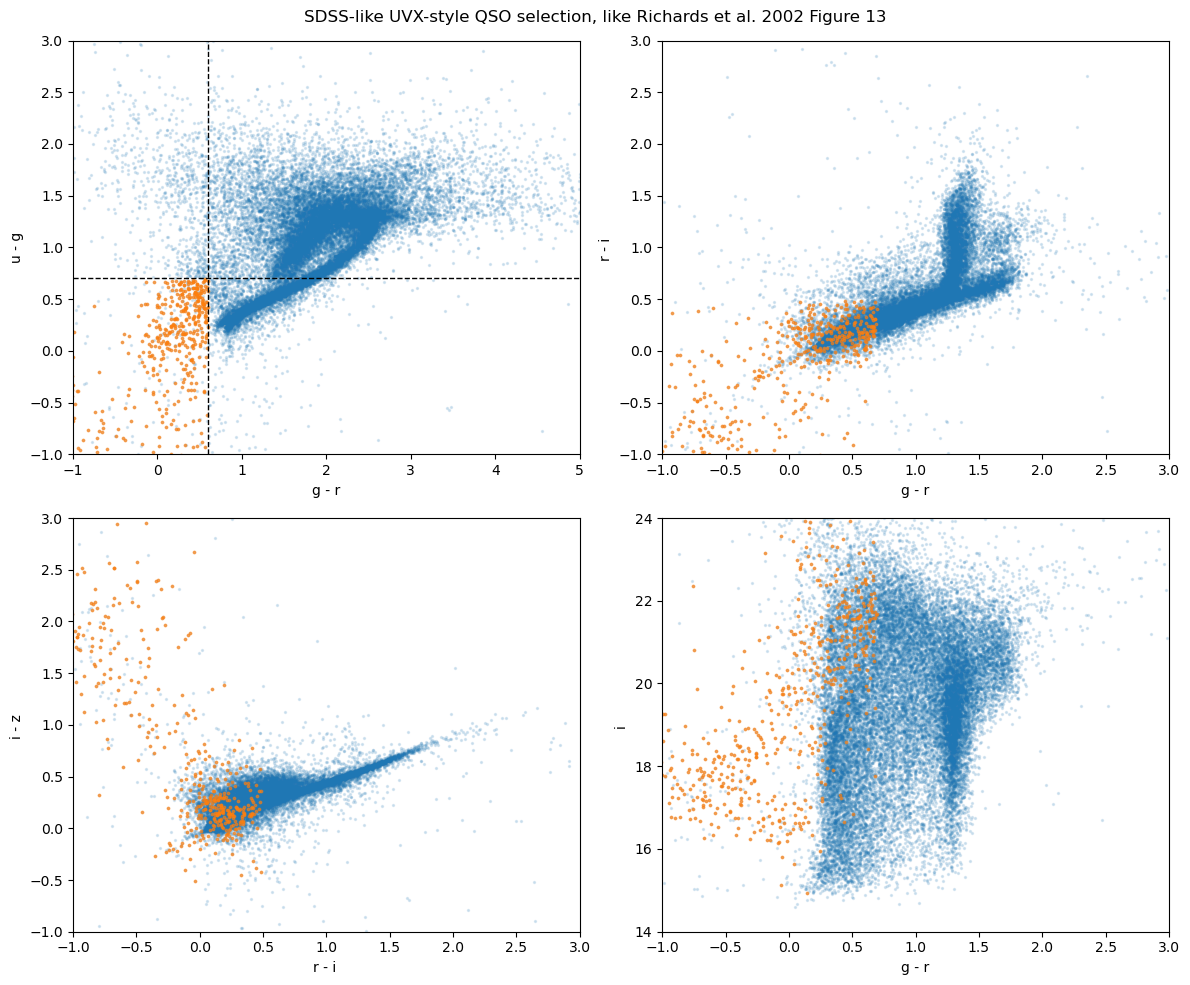

In [89]:
# Simple Rubin-only (ugrizy) UVX QSO selection
# Assumes you have AB mags (ideally dereddened). Edit the column names below.

import numpy as np
import matplotlib.pyplot as plt

# Pick the dataframe you want to work on
df = DP1_ZTF_xmatch  # or DP1_ZTF_first_selection

# --- EDIT THESE to match your Rubin magnitude columns ---
U = "u_psfMag_object_lc"
G = "g_psfMag_object_lc"
R = "r_psfMag_object_lc"
I = "i_psfMag_object_lc"
Z = "z_psfMag_object_lc"   
# Y = "y_psfMag_object_lc"   # optional

missing = [c for c in [U, G, R, I] if c not in df.columns]
if missing:
    raise KeyError(f"Missing Rubin mag columns: {missing}. Available columns include: {list(df.columns)[:30]} ...")

work = df[[U, G, R, I, Z]].copy()
work["u_g"] = work[U] - work[G]
work["g_r"] = work[G] - work[R]
work["r_i"] = work[R] - work[I]
work["i_z"] = work[I] - work[Z]

# Very simple UV-excess QSO cut (tune thresholds if needed)
work["is_qso_uvx"] = (
    np.isfinite(work[["u_g", "g_r", "r_i"]]).all(axis=1)
    & (work["u_g"] < 0.6)
    & (work["g_r"] < 0.7)
    & (work["r_i"] < 0.5)
)

print(f"UVX QSO candidates: {work['is_qso_uvx'].sum()} / {len(work)}")

# Quick diagnostic plot
plt.figure(figsize=(12, 10))

plt.suptitle("SDSS-like UVX-style QSO selection, like Richards et al. 2002 Figure 13")
plt.subplot(2,2,1)
plt.scatter(work["u_g"], work["g_r"], s=2, alpha=0.15)
plt.scatter(work.loc[work["is_qso_uvx"], "u_g"], work.loc[work["is_qso_uvx"], "g_r"], s=3, alpha=0.6)
plt.axhline(0.7, color="k", linestyle="--", linewidth=1)
plt.axvline(0.6, color="k", linestyle="--", linewidth=1)
plt.xlabel("g - r")
plt.ylabel("u - g")
plt.xlim(-1, 5.0)
plt.ylim(-1, 3.0)
plt.tight_layout()


plt.subplot(2,2,2)
plt.scatter(work["g_r"], work["r_i"], s=2, alpha=0.15)
plt.scatter(work.loc[work["is_qso_uvx"], "g_r"], work.loc[work["is_qso_uvx"], "r_i"], s=3, alpha=0.6)
plt.xlabel("g - r")
plt.ylabel("r - i ")
plt.xlim(-1, 3.0)
plt.ylim(-1, 3.0)
plt.tight_layout()

plt.subplot(2,2,3)
plt.scatter(work["r_i"], work["i_z"], s=2, alpha=0.15)
plt.scatter(work.loc[work["is_qso_uvx"], "r_i"], work.loc[work["is_qso_uvx"], "i_z"], s=3, alpha=0.6)
plt.xlabel("r - i ")
plt.ylabel("i - z ")
plt.xlim(-1, 3.0)
plt.ylim(-1, 3.0)
plt.tight_layout()


plt.subplot(2,2,4)
plt.scatter(work["g_r"], work[I], s=2, alpha=0.15)
plt.scatter(work.loc[work["is_qso_uvx"], "g_r"], work.loc[work["is_qso_uvx"], I], s=3, alpha=0.6)
plt.xlabel("g - r")
plt.ylabel("i ")
plt.xlim(-1, 3.0)
plt.ylim(14, 24)
plt.tight_layout()


# Carry this flag back into your main dataframe:
DP1_ZTF_xmatch = DP1_ZTF_xmatch.join(work[["u_g","g_r","r_i","i_z","is_qso_uvx"]])

In [90]:
# Variability selection (ZTF object-level stats)
# Make a boolean flag AND (optionally) a filtered table.

mask_var = (
    (DP1_ZTF_xmatch["ngoodobs_ZTF_DR23_Objects"] > 50)
    & (DP1_ZTF_xmatch["medianabsdev_ZTF_DR23_Objects"] > 0.1)
    & (DP1_ZTF_xmatch["medianmag_ZTF_DR23_Objects"] < 20)
)

# Boolean flag on the full table
DP1_ZTF_xmatch["is_qso_var"] = mask_var

# Optional: a filtered table of just the selected objects
DP1_ZTF_first_selection = DP1_ZTF_xmatch.loc[mask_var].copy()

print(f"Variability-selected objects: {mask_var.sum()} / {len(mask_var)}")

Variability-selected objects: 570 / 53739


UVX-selected: 591
VAR-selected: 570
BOTH: 11


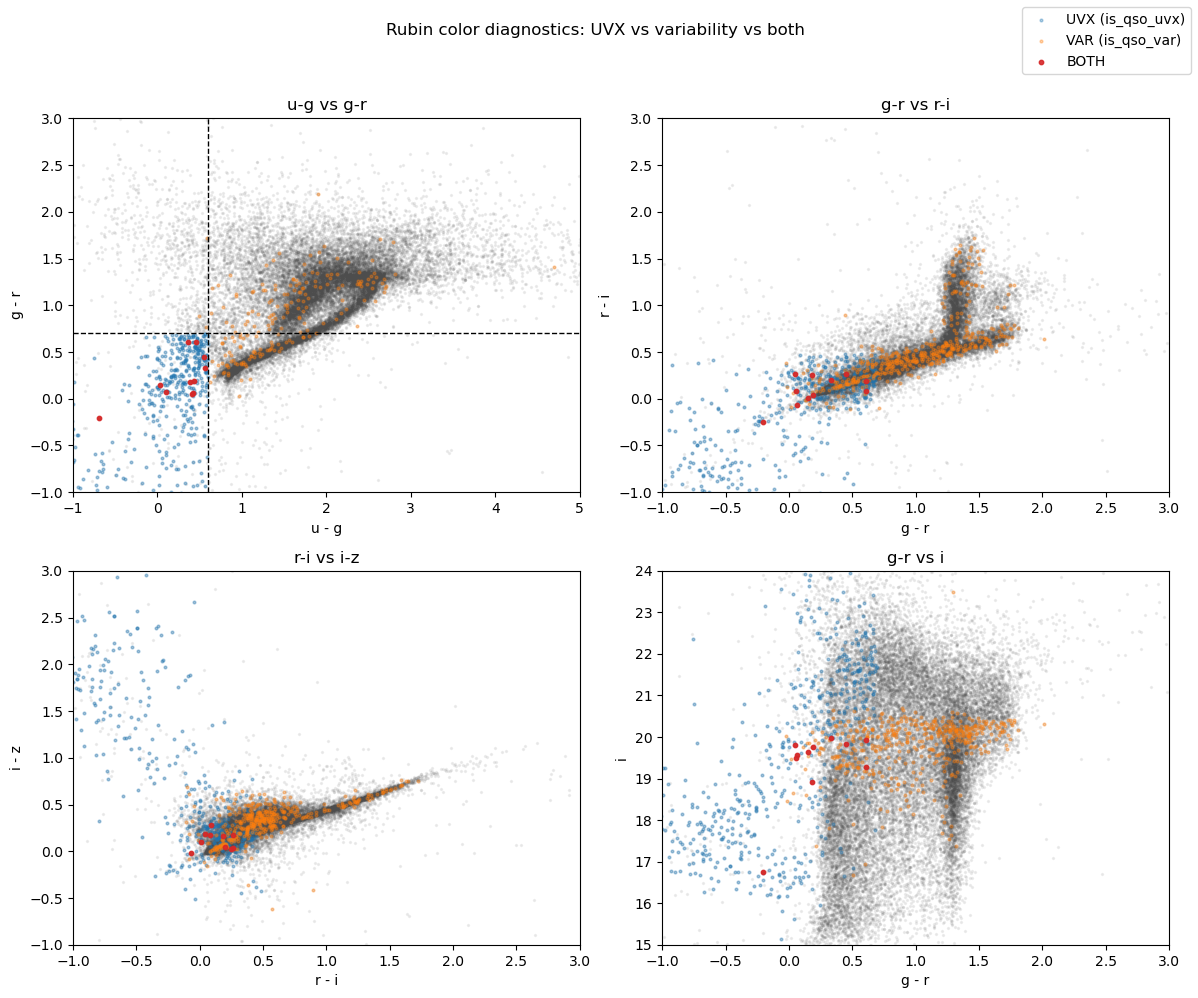

In [91]:
# Rubin color-color diagnostic plots with BOTH selections
# - grey: all objects
# - blue: UVX selection (is_qso_uvx)
# - orange: variability selection (is_qso_var)
# - red: pass BOTH

required = [U, G, R, I, Z]
missing = [c for c in required if c not in DP1_ZTF_xmatch.columns]
if missing:
    raise KeyError(f"Missing Rubin columns: {missing}")

if "is_qso_uvx" not in DP1_ZTF_xmatch.columns:
    raise KeyError("Missing is_qso_uvx. Run the UVX selection cell first.")
if "is_qso_var" not in DP1_ZTF_xmatch.columns:
    raise KeyError("Missing is_qso_var. Run the variability selection cell first.")

work_both = DP1_ZTF_xmatch[[U, G, R, I, Z, "is_qso_uvx", "is_qso_var"]].copy()
work_both["u_g"] = DP1_ZTF_xmatch['u_g']
work_both["g_r"] = DP1_ZTF_xmatch['g_r']
work_both["r_i"] = DP1_ZTF_xmatch['r_i']
work_both["i_z"] = DP1_ZTF_xmatch['i_z']

sel_uvx = work_both["is_qso_uvx"].astype(bool)
sel_var = work_both["is_qso_var"].astype(bool)
sel_both = sel_uvx & sel_var

print(f"UVX-selected: {sel_uvx.sum()}")
print(f"VAR-selected: {sel_var.sum()}")
print(f"BOTH: {sel_both.sum()}")

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Rubin color diagnostics: UVX vs variability vs both")

# Styling
base_kw = dict(s=2, alpha=0.08, color="0.3")
uvx_kw = dict(s=4, alpha=0.35, color="tab:blue", label="UVX (is_qso_uvx)")
var_kw = dict(s=4, alpha=0.35, color="tab:orange", label="VAR (is_qso_var)")
both_kw = dict(s=10, alpha=0.9, color="tab:red", label="BOTH")

# Panel 1: u-g vs g-r
ax[0, 0].scatter(work_both["u_g"], work_both["g_r"], **base_kw)
ax[0, 0].scatter(work_both.loc[sel_uvx, "u_g"], work_both.loc[sel_uvx, "g_r"], **uvx_kw)
ax[0, 0].scatter(work_both.loc[sel_var, "u_g"], work_both.loc[sel_var, "g_r"], **var_kw)
ax[0, 0].scatter(work_both.loc[sel_both, "u_g"], work_both.loc[sel_both, "g_r"], **both_kw)
ax[0, 0].axhline(0.7, color="k", linestyle="--", linewidth=1)
ax[0, 0].axvline(0.6, color="k", linestyle="--", linewidth=1)
ax[0, 0].set_xlabel("u - g")
ax[0, 0].set_ylabel("g - r")
ax[0, 0].set_xlim(-1, 5.0)
ax[0, 0].set_ylim(-1, 3.0)
ax[0, 0].set_title("u-g vs g-r")

# Panel 2: g-r vs r-i
ax[0, 1].scatter(work_both["g_r"], work_both["r_i"], **base_kw)
ax[0, 1].scatter(work_both.loc[sel_uvx, "g_r"], work_both.loc[sel_uvx, "r_i"], **uvx_kw)
ax[0, 1].scatter(work_both.loc[sel_var, "g_r"], work_both.loc[sel_var, "r_i"], **var_kw)
ax[0, 1].scatter(work_both.loc[sel_both, "g_r"], work_both.loc[sel_both, "r_i"], **both_kw)
ax[0, 1].set_xlabel("g - r")
ax[0, 1].set_ylabel("r - i")
ax[0, 1].set_xlim(-1, 3.0)
ax[0, 1].set_ylim(-1, 3.0)
ax[0, 1].set_title("g-r vs r-i")

# Panel 3: r-i vs i-z
ax[1, 0].scatter(work_both["r_i"], work_both["i_z"], **base_kw)
ax[1, 0].scatter(work_both.loc[sel_uvx, "r_i"], work_both.loc[sel_uvx, "i_z"], **uvx_kw)
ax[1, 0].scatter(work_both.loc[sel_var, "r_i"], work_both.loc[sel_var, "i_z"], **var_kw)
ax[1, 0].scatter(work_both.loc[sel_both, "r_i"], work_both.loc[sel_both, "i_z"], **both_kw)
ax[1, 0].set_xlabel("r - i")
ax[1, 0].set_ylabel("i - z")
ax[1, 0].set_xlim(-1, 3.0)
ax[1, 0].set_ylim(-1, 3.0)
ax[1, 0].set_title("r-i vs i-z")

# Panel 4: g-r vs i magnitude
ax[1, 1].scatter(work_both["g_r"], work_both[I], **base_kw)
ax[1, 1].scatter(work_both.loc[sel_uvx, "g_r"], work_both.loc[sel_uvx, I], **uvx_kw)
ax[1, 1].scatter(work_both.loc[sel_var, "g_r"], work_both.loc[sel_var, I], **var_kw)
ax[1, 1].scatter(work_both.loc[sel_both, "g_r"], work_both.loc[sel_both, I], **both_kw)
ax[1, 1].invert_yaxis()
ax[1, 1].set_xlabel("g - r")
ax[1, 1].set_ylabel("i")
ax[1, 1].set_xlim(-1, 3.0)
ax[1, 1].set_ylim(15, 24) 
ax[1, 1].set_title("g-r vs i")

# One shared legend
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", frameon=True)

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [92]:
sel_uvx = DP1_ZTF_xmatch["is_qso_uvx"].astype(bool)
sel_var = DP1_ZTF_xmatch["is_qso_var"].astype(bool)
sel_both = sel_uvx & sel_var
DP1_ZTF_xmatch_selected = DP1_ZTF_xmatch.loc[sel_both].copy()

In [121]:
len(DP1_ZTF_xmatch_selected)

11

## 3. Get lightcurves for the first selection of objects

In [93]:
# load the lightcurves for ZTF DR23
path = UPath(
    's3://ipac-irsa-ztf/contributed/dr23/lc/hats',
    anon=True,
    client_kwargs={
        "region_name": "us-east-1",
        "endpoint_url": "https://s3.us-east-1.amazonaws.com",
    },
)

lc_ZTF_23 = lsdb.open_catalog(path)
lc_ZTF_23

,objectid,filterid,objra,objdec,lightcurve
npartitions=9933,,,,,
"Order: 4, Pixel: 0",int64[pyarrow],int8[pyarrow],float[pyarrow],float[pyarrow],"nested<hmjd: [double], mag: [float], magerr: [..."
"Order: 4, Pixel: 1",...,...,...,...,...
...,...,...,...,...,...
"Order: 5, Pixel: 12286",...,...,...,...,...
"Order: 5, Pixel: 12287",...,...,...,...,...


In [150]:
# perform crossmatch between selected DP1_ZTF objects and lightcurves
# seems silly to do crossmatch rather then join or index search
ZTF_DP1_lc_plan = lsdb.crossmatch(DP1_ZTF_xmatch_selected, lc_ZTF_23, radius_arcsec=0.1, ra_column='coord_ra_object_lc', dec_column='coord_dec_object_lc')

In [151]:
ZTF_DP1_lc = ZTF_DP1_lc_plan.compute()

In [155]:
len(ZTF_DP1_lc)

11

In [156]:
# Save the lightcurve crossmatch to a parquet file
ZTF_DP1_lc.to_parquet('/sdf/home/n/ncaplar/github/short_var_AGN/ZTF_DP1_lc.parquet')

# Analysis

In [157]:
# Load the lightcurve crossmatch to a parquet file
ZTF_DP1_lc = read_parquet('/sdf/home/n/ncaplar/github/short_var_AGN/ZTF_DP1_lc.parquet')

In [158]:
ZTF_DP1_lc['objectid_ZTF_DR23_Lightcurves', 'oid_ZTF_DR23_Objects_left', 'ra_ZTF_DR23_Objects_left',	'dec_ZTF_DR23_Objects_left','objra_ZTF_DR23_Lightcurves',	'objdec_ZTF_DR23_Lightcurves', '_dist_arcsec']

,objectid_ZTF_DR23_Lightcurves,oid_ZTF_DR23_Objects_left,ra_ZTF_DR23_Objects_left,dec_ZTF_DR23_Objects_left,objra_ZTF_DR23_Lightcurves,objdec_ZTF_DR23_Lightcurves,_dist_arcsec
0,258207200019795,258207200019795,95.575542,-25.060481,95.575546,-25.06048,0.030594
1,258108100008711,258108100008711,94.91958,-24.646733,94.919579,-24.646732,0.030664
2,258207200008190,258207200008190,95.419175,-24.811243,95.419174,-24.811243,0.047845
3,1246205100003811,1246205100003811,53.457374,-28.37869,53.457375,-28.378689,0.080777
4,252202300011587,252202300011587,53.756017,-27.884671,53.756016,-27.884672,0.058452
5,252102300012695,252102300012695,53.729568,-27.800937,53.729568,-27.800938,0.078286
6,252202300004073,252202300004073,53.112555,-27.684835,53.112556,-27.684835,0.059464
7,252202300004008,252202300004008,53.110413,-27.676624,53.110413,-27.676624,0.067496
8,252202300003454,252202300003454,53.43804,-27.600274,53.438042,-27.600273,0.008691
9,252203400008891,252203400008891,52.748527,-27.638189,52.748528,-27.638189,0.099731


### 4.1. Single lightcurve

In [159]:
# index to loop over the lightcurves
i_lc = 3 

single_lc_ZTF = ZTF_DP1_lc.iloc[i_lc]['lightcurve_ZTF_DR23_Lightcurves']
single_lc_Rubin = ZTF_DP1_lc.iloc[i_lc]['objectForcedSource_object_lc_left']
# verify that the objectids match
print(ZTF_DP1_lc.iloc[i_lc]['objectid_ZTF_DR23_Lightcurves'], ZTF_DP1_lc.iloc[i_lc]['oid_ZTF_DR23_Objects_left'])


1246205100003811 1246205100003811


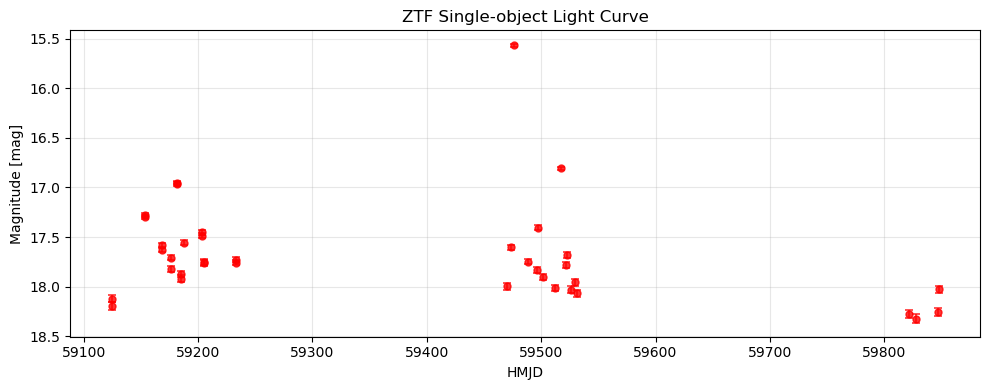

In [160]:
plt.figure(figsize=(10, 4))

fid = ZTF_DP1_lc.iloc[0]["filterid_ZTF_DR23_Lightcurves"]

# map filterid -> color
fid_to_color = {2: "red", 1: "green", 3: "brown"}

if np.isscalar(fid):
    colors = fid_to_color.get(int(fid), "gray")
else:
    colors = np.array([fid_to_color.get(int(x), "gray") for x in fid])


plt.errorbar(
    single_lc_ZTF["hmjd"],
    single_lc_ZTF["mag"],
    yerr=single_lc_ZTF["magerr"],
    fmt="o",
    ms=5,
    elinewidth=1.2,
    capsize=3,
    capthick=1.2,
    alpha=0.8,
    c=colors
)

plt.xlabel("HMJD")
plt.ylabel("Magnitude [mag]")
plt.title("ZTF Single-object Light Curve")

plt.gca().invert_yaxis()  # magnitudes: brighter = up
plt.grid(True, which="both", alpha=0.3)

plt.tight_layout()
plt.show()

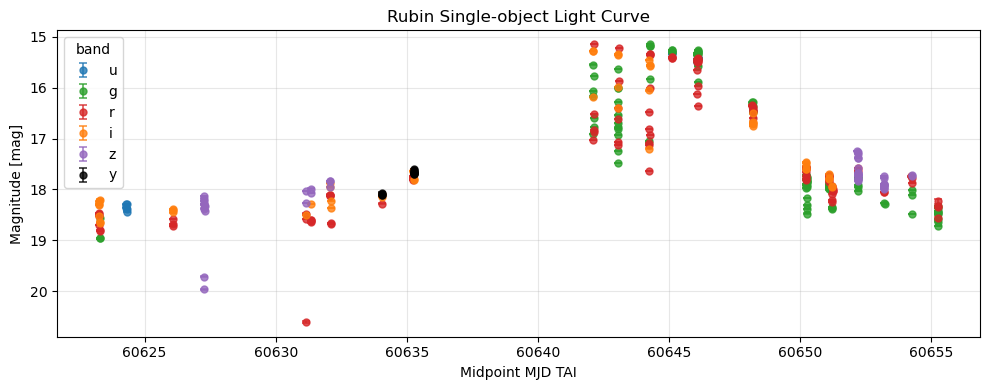

In [161]:
plt.figure(figsize=(10, 4))

# Color Rubin points by band (legend order: ugrizy; u is blue)
required_cols = ["midpointMjdTai", "psfMag", "psfMagErr", "band"]
missing = [c for c in required_cols if c not in single_lc_Rubin.columns]
if missing:
    raise KeyError(f"single_lc_Rubin is missing columns: {missing}. Available: {list(single_lc_Rubin.columns)}")

# Use a fixed order for plotting + legend
band_order = ["u", "g", "r", "i", "z", "y"]

# Choose colors (requested: u -> blue)
band_to_color = {
    "u": "tab:blue",
    "g": "tab:green",
    "r": "tab:red",
    "i": "tab:orange",
    "z": "tab:purple",
    "y": "black",
}

bands = (
    pd.Series(single_lc_Rubin["band"])
    .astype(str)
    .str.strip()
    .str.lower()
)
present = set(bands.unique())

for band in [b for b in band_order if b in present]:
    sel = bands == band
    plt.errorbar(
        single_lc_Rubin.loc[sel, "midpointMjdTai"],
        single_lc_Rubin.loc[sel, "psfMag"],
        yerr=single_lc_Rubin.loc[sel, "psfMagErr"],
        fmt="o",
        ms=5,
        elinewidth=1.2,
        capsize=3,
        capthick=1.2,
        alpha=0.8,
        color=band_to_color.get(band, "gray"),
        label=band,
    )

plt.xlabel("Midpoint MJD TAI")
plt.ylabel("Magnitude [mag]")
plt.title("Rubin Single-object Light Curve")

plt.gca().invert_yaxis()  # magnitudes: brighter = up
plt.grid(True, which="both", alpha=0.3)
plt.legend(title="band", frameon=True)

plt.tight_layout()
plt.show()
